# Low mass diphoton search: signal modelling
### Linear interpolation of the triple gaussian parameters 

This notebook shows the comparison between the results of the triple gaussian fits for each mass point in two scenarios:
* All parameters are freely floating
* The mean values are frozen in the fit

The behaviour of a linear interpolation of the best estimate of each parameter for each mass point is shown.

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mpl
#mpl.rcParams['figure.dpi'] = 150

import scipy
from scipy.optimize import curve_fit
from scipy import misc
from scipy import stats
#from scipy.odr import *
#from pylab import * 

import statsmodels.api as sm
import statsmodels.formula.api as sm

import requests
import math
import re
import csv
import mplhep as hep

In [2]:
# PARAMETERS
mass = np.array([5, 10, 15, 20, 25, 30, 35, 40, 45, 50, 55, 60, 65, 70])

# Restricting fit range to the peak region (-3sigma, +3sigma)
# -----------------------------------------------------------
frac1 = np.array([0.616941, 0.786107, 0.839527, 0.662698, 0.511641, 0.525997, 0.296808, 0.507125, 0.714972, 0.764215, 0.141333, 0.394128, 0.681711, 0.629811]) 
frac2 = np.array([0.908863, 0.929146, 0.00793432, 0.218216, 0.409684, 0.0504783, 0.130418, 0.162328, 0.869985, 0.946381, 0.249453, 0.828113, 0.776842, 0.669321]) 
mean1 = np.array([4.9872, 10.0093, 14.968, 19.9323, 25.0551, 29.9503, 35.0216, 39.9755, 44.9384, 49.9409, 54.9957, 59.9928, 64.9466, 69.9075]) 
mean2 = np.array([5, 8.65064, 16.4387, 20.2743, 24.7024, 25.7202, 33.6065, 39.0571, 44.2623, 49.2855, 54.4261, 59.7935, 64.3948, 69.3615]) 
mean3 = np.array([5.96956, 11.8907, 14.6674, 19.7685, 24.7828, 29.8662, 34.8912, 39.8074, 46.2013, 51.7481, 54.8818, 58.5878, 64.3462, 69.9058]) 
sigma1 = np.array([0.1, 0.154047, 0.228499, 0.258232, 0.265931, 0.314271, 0.285999, 0.416409, 0.458451, 0.573158, 0.313046, 0.517024, 0.660719, 0.650068]) 
sigma2 = np.array([2.41388, 1.86957, 1.63275, 0.303687, 0.300393, 1.55073, 1.60056, 1.59334, 1.0042, 1.14352, 1.45882, 0.853111, 1.35748, 1.43451]) 
sigma3 = np.array([0.479238, 0.311122, 7.48206, 0.647163, 0.821263, 0.665501, 0.608116, 0.790149, 0.351417, 0.301649, 0.692229, 1.84803, 1.38103, 1.17401]) 
frac1_err = np.array([0.688341, 0.569376, 0.206053, 1.10364, 1.62412, 0.724072, 1.11734, 1.23293, 0.514726, 0.523548, 1.1092, 1.33282, 0.315828, 1.2972]) 
frac2_err = np.array([0.241961, 0.616911, 0.218681, 0.829728, 0.665893, 0.906219, 0.514639, 0.903359, 0.934441, 0.770588, 0.600926, 0.881743, 0.611437, 0.628113]) 
mean1_err = np.array([0.306493, 0.112817, 0.0908072, 0.434391, 0.902711, 0.157572, 0.277435, 0.215386, 0.147939, 0.177278, 0.412849, 0.427341, 0.194531, 0.284766]) 
mean2_err = np.array([0.00001, 2.36502, 2.2143, 5.99852, 2.56425, 7.97274, 9.78187, 11.3017, 2.4347, 1.99916, 1.33508, 1.06198, 4.08843, 6.71428]) 
mean3_err = np.array([1.11984, 2.0464, 2.50554, 0.852838, 0.552944, 0.621105, 0.291228, 0.929034, 0.978362, 0.853967, 0.347962, 6.39131, 18.741, 9.28738]) 
sigma1_err = np.array([0.55078, 0.134821, 0.0835539, 0.252427, 0.412495, 0.236319, 0.323419, 0.350385, 0.200814, 0.230197, 0.608327, 0.678947, 0.199427, 0.415275]) 
sigma2_err = np.array([0.936492, 1.9108, 1.13456, 1.50125, 2.36594, 1.94021, 1.57663, 1.65103, 0.841381, 0.677882, 1.91895, 1.6133, 1.73782, 1.5363]) 
sigma3_err = np.array([2.09388, 7.114, 7.17528, 0.685283, 0.97078, 0.638206, 0.476611, 1.15237, 6.87874, 8.72117, 0.574366, 5.43464, 8.69121, 8.66027])

# Simple fits with mean1, mean2, mean3 frozen (=mf)
mf_frac1 = np.array([0.625779, 0.784049, 0.809611, 0.80111, 0.731857, 0.686968, 0.637502, 0.660996, 0.677942, 0.289181, 0.16819, 0.545386, 0.56857, 0.611627]) 
mf_frac2 = np.array([0.399245, 0.405339, 0.637501, 0.693729, 0.640065, 0.631159, 0.601895, 0.583014, 0.660138, 0.250919, 0.18884, 0.406064, 0.36028, 0.161766]) 
mf_sigma1 = np.array([0.1, 0.152032, 0.222348, 0.285432, 0.317535, 0.349399, 0.395284, 0.457787, 0.572137, 0.89138, 0.322666, 0.579111, 0.622214, 0.633486]) 
mf_sigma2 = np.array([0.56062, 0.437248, 0.637811, 0.466651, 0.63581, 0.706258, 0.904774, 0.966719, 1.1639, 1.12281, 1.63637, 1.51087, 1.54133, 0.859448]) 
mf_sigma3 = np.array([0.484669, 0.78559, 0.849562, 0.551419, 0.650482, 0.690019, 0.69401, 0.912817, 0.237354, 0.490589, 0.736486, 0.832178, 1.05232, 1.4097]) 
mf_frac1_err = np.array([0.810679, 0.736269, 0.325258, 0.260366, 0.335833, 0.355879, 0.458704, 0.484452, 0.405408, 0.618869, 0.613935, 0.870662, 0.874768, 0.75485]) 
mf_frac2_err = np.array([0.527997, 0.590313, 0.670387, 0.761352, 0.742504, 0.739839, 0.777574, 0.788488, 0.828221, 0.34622, 0.219338, 0.537795, 0.503291, 0.751834]) 
mf_sigma1_err = np.array([0.84334, 0.45822, 0.108064, 0.119407, 0.143222, 0.14756, 0.198371, 0.21045, 0.236183, 0.773643, 0.531378, 0.322161, 0.311596, 0.703642]) 
mf_sigma2_err = np.array([2.11667, 2.11572, 2.60129, 0.534754, 0.661289, 0.593436, 0.625857, 0.565673, 0.58518, 0.725729, 1.05556, 0.896173, 1.36034, 2.01914]) 
mf_sigma3_err = np.array([3.69443, 3.68506, 5.54086, 1.3744, 1.07676, 0.824554, 0.586926, 1.14637, 0.41577, 0.3601, 0.332333, 0.602365, 0.890163, 1.26983]) 

v_m = []
v_q = []

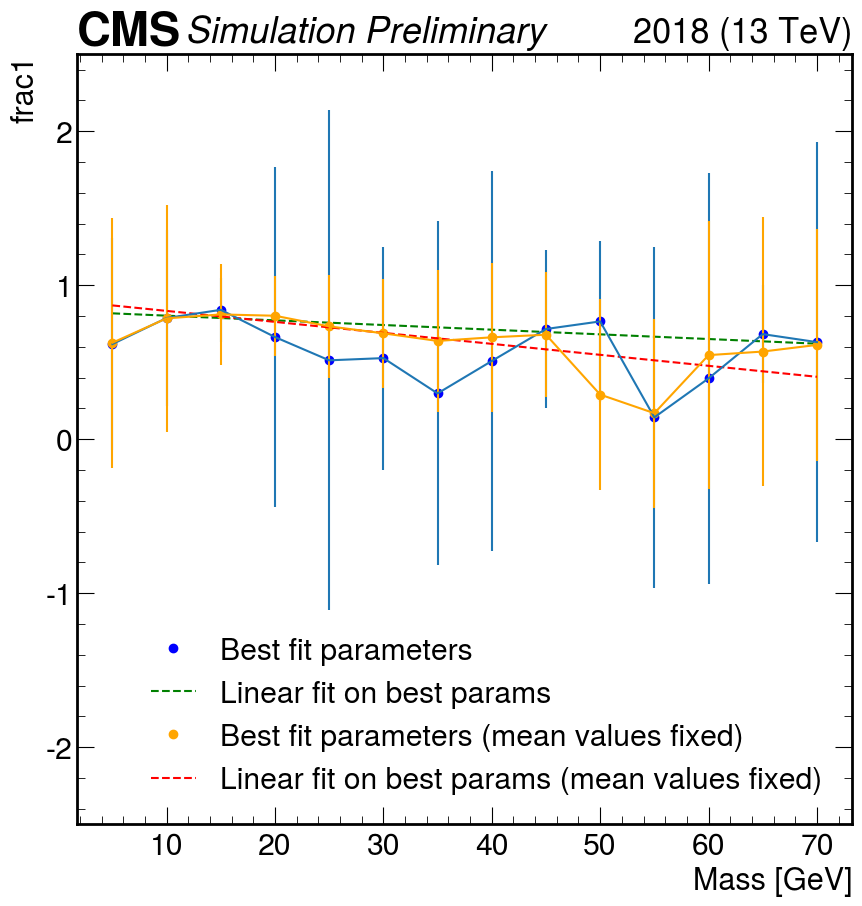

In [12]:
p = np.polyfit(mass, frac1, 1, w=1/frac1_err)
##print(p)
x1 = np.linspace(5,70) 
f1 = np.polyval(p, x1)

p_mf = np.polyfit(mass, mf_frac1, 1, w=1/mf_frac1_err)
f1_mf = np.polyval(p_mf, x1)
v_m.append(p_mf[0])
v_q.append(p_mf[1])

plt.plot(mass, frac1, 'o', color="blue", label='Best fit parameters')
plt.errorbar(mass, frac1, yerr=frac1_err)
plt.plot(x1,f1,'g--', label='Linear fit on best params') 
plt.plot(mass, mf_frac1, 'o', color="orange", label='Best fit parameters (mean values fixed)')
plt.errorbar(mass, mf_frac1, yerr=mf_frac1_err, color="orange")
plt.plot(x1,f1_mf,'r--', label='Linear fit on best params (mean values fixed)') 
plt.legend(loc='lower right')

plt.style.use(hep.style.ROOT)
# Overall - both left and right annotation
hep.cms.label("Preliminary", data=False, year="2018")
#hep.cms.label("", data=True, lumi=96.6, year="2017 + 2018")

plt.xlabel('Mass [GeV]', fontsize=22)
plt.ylabel('frac1', fontsize=22)
plt.ylim(-2.5, 2.5)
plt.savefig('simpleFits/frac1_fit.pdf', dpi=1200)
plt.savefig('simpleFits/frac1_fit.png', dpi=1200)

[-0.00583222  0.60324553]


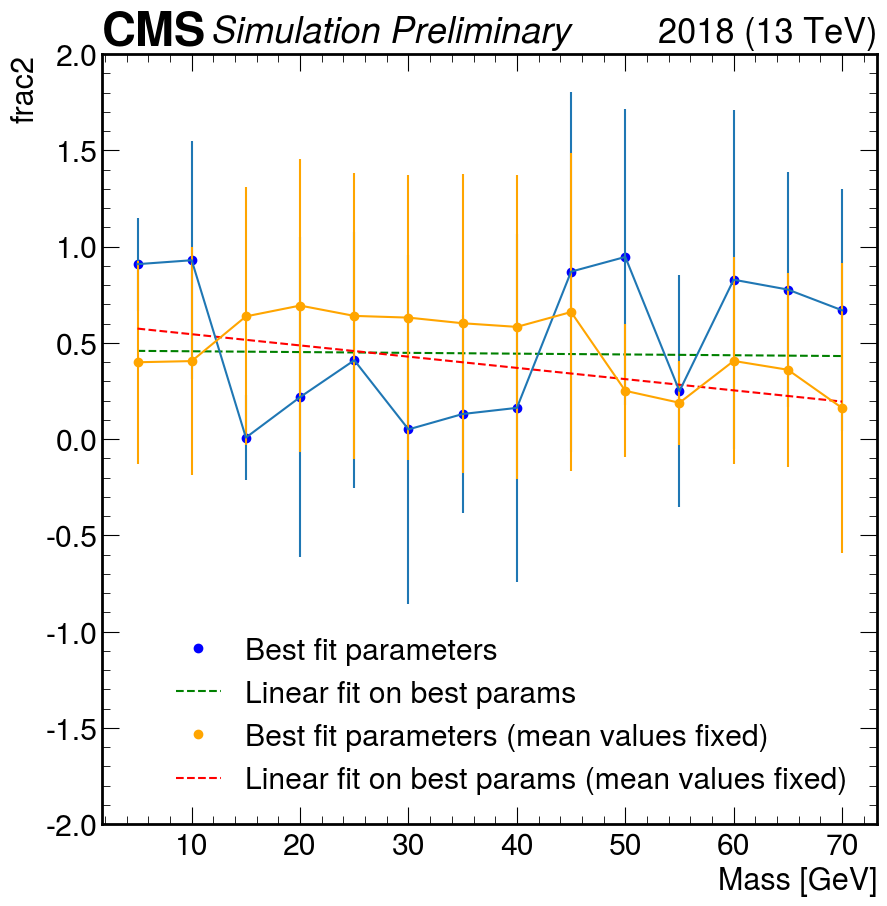

In [4]:
#plt.scatter(mass, frac2, color="blue")

p = np.polyfit(mass, frac2, 1, w=1/frac2_err)
#print(p)
x1 = np.linspace(5,70)
f1 = np.polyval(p,x1)

p_mf = np.polyfit(mass, mf_frac2, 1, w=1/mf_frac2_err)
print(p_mf)
f1_mf = np.polyval(p_mf, x1)
v_m.append(p_mf[0])
v_q.append(p_mf[1])

plt.plot(mass, frac2, 'o', color="blue", label='Best fit parameters')
plt.errorbar(mass, frac2, yerr=frac2_err)
plt.plot(x1,f1,'g--', label='Linear fit on best params')
plt.plot(mass, mf_frac2, 'o', color="orange", label='Best fit parameters (mean values fixed)')
plt.errorbar(mass, mf_frac2, yerr=mf_frac2_err, color="orange")
plt.plot(x1,f1_mf,'r--', label='Linear fit on best params (mean values fixed)')
plt.legend(loc='lower right')

plt.style.use(hep.style.ROOT)
# Overall - both left and right annotation
hep.cms.label("Preliminary", data=False, year="2018")
#hep.cms.label("", data=True, lumi=96.6, year="2017 + 2018")

plt.xlabel('Mass [GeV]', fontsize=22)
plt.ylabel('frac2', fontsize=22)
plt.ylim(-2.0, 2.0)
plt.savefig('simpleFits/frac2_fit.pdf', dpi=1200)
plt.savefig('simpleFits/frac2_fit.png', dpi=1200)

[0.00844028 0.10557534]


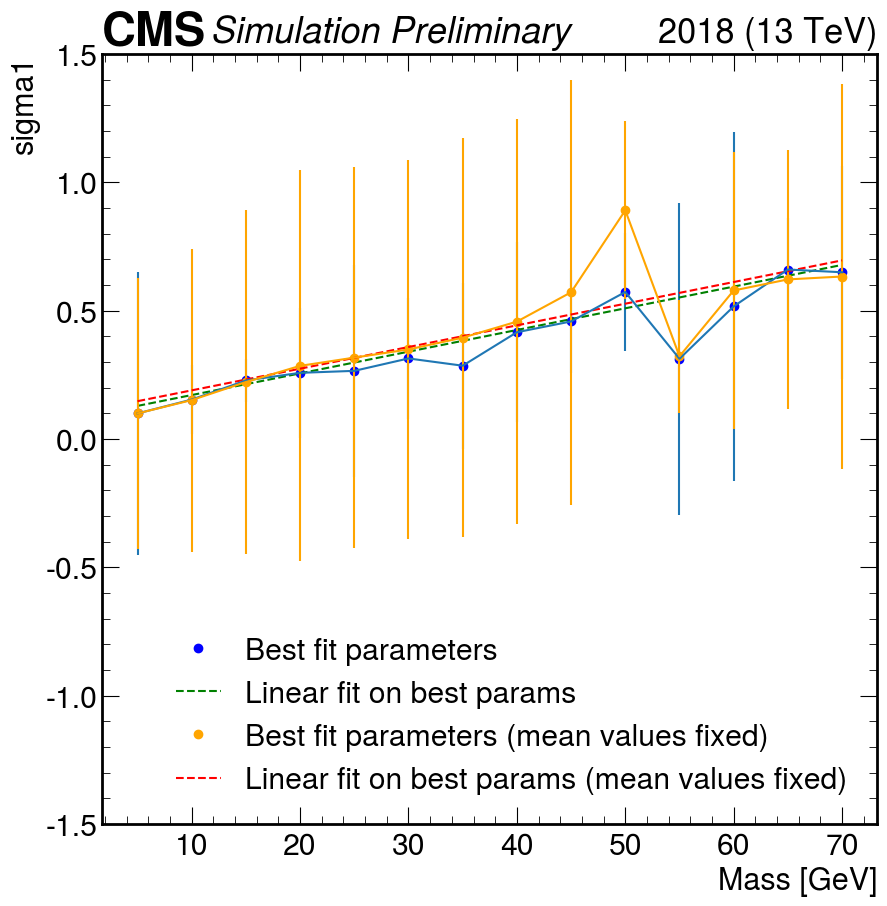

In [5]:
#p_sigma1 = plt.scatter(mass, sigma1, color="blue")

p = np.polyfit(mass, sigma1, 1, w=1/sigma1_err)
#print(p)
x1 = np.linspace(5,70)
f1 = np.polyval(p,x1)

p_mf = np.polyfit(mass, mf_sigma1, 1, w=1/mf_sigma1_err)
print(p_mf)
f1_mf = np.polyval(p_mf, x1)
v_m.append(p_mf[0])
v_q.append(p_mf[1])

plt.plot(mass, sigma1, 'o', color="blue", label='Best fit parameters')
plt.errorbar(mass, sigma1, yerr=sigma1_err)
plt.plot(x1,f1,'g--', label='Linear fit on best params') 
plt.plot(mass, mf_sigma1, 'o', color="orange", label='Best fit parameters (mean values fixed)')
plt.errorbar(mass, mf_sigma1, yerr=mf_frac2_err, color="orange")
plt.plot(x1,f1_mf,'r--', label='Linear fit on best params (mean values fixed)')

plt.style.use(hep.style.ROOT)
# Overall - both left and right annotation
hep.cms.label("Preliminary", data=False, year="2018")
#hep.cms.label("", data=True, lumi=96.6, year="2017 + 2018")

plt.xlabel('Mass [GeV]', fontsize=22)
plt.ylabel('sigma1', fontsize=22)
plt.ylim(-1.5, 1.5)
plt.legend(loc='lower right')
plt.savefig('simpleFits/sigma1_fit.pdf', dpi=1000)
plt.savefig('simpleFits/sigma1_fit.png', dpi=1000)

[0.02277089 0.07293725]


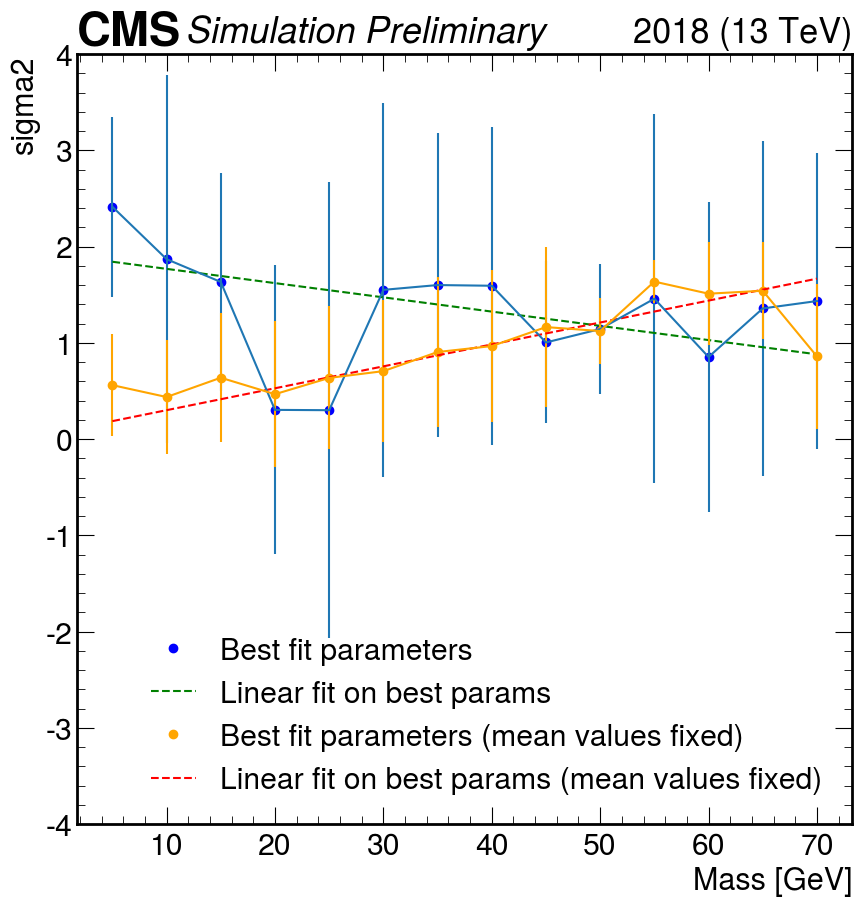

In [13]:
#p_sigma2 = plt.scatter(mass, sigma2, color="blue")

p = np.polyfit(mass, sigma2, 1, w=1/sigma2_err)
#print(p)
x1 = np.linspace(5,70)
f1 = np.polyval(p,x1)

p_mf = np.polyfit(mass, mf_sigma2, 1, w=1/mf_sigma2_err)
print(p_mf)
f1_mf = np.polyval(p_mf, x1)
v_m.append(p_mf[0])
v_q.append(p_mf[1])

plt.plot(mass, sigma2, 'o', color="blue", label='Best fit parameters')
plt.errorbar(mass, sigma2, yerr=sigma2_err)
plt.plot(x1,f1,'g--', label='Linear fit on best params') 
plt.plot(mass, mf_sigma2, 'o', color="orange", label='Best fit parameters (mean values fixed)')
plt.errorbar(mass, mf_sigma2, yerr=mf_frac2_err, color="orange")
plt.plot(x1,f1_mf,'r--', label='Linear fit on best params (mean values fixed)')

plt.style.use(hep.style.ROOT)
# Overall - both left and right annotation
hep.cms.label("Preliminary", data=False, year="2018")
#hep.cms.label("", data=True, lumi=96.6, year="2017 + 2018")

plt.xlabel('Mass [GeV]', fontsize=22)
plt.ylabel('sigma2', fontsize=22)
plt.ylim(-4.0, 4.0)
plt.legend(loc='lower right')
plt.savefig('simpleFits/sigma2_fit.pdf', dpi=1000)
plt.savefig('simpleFits/sigma2_fit.png', dpi=1000)

[0.00875934 0.19510179]


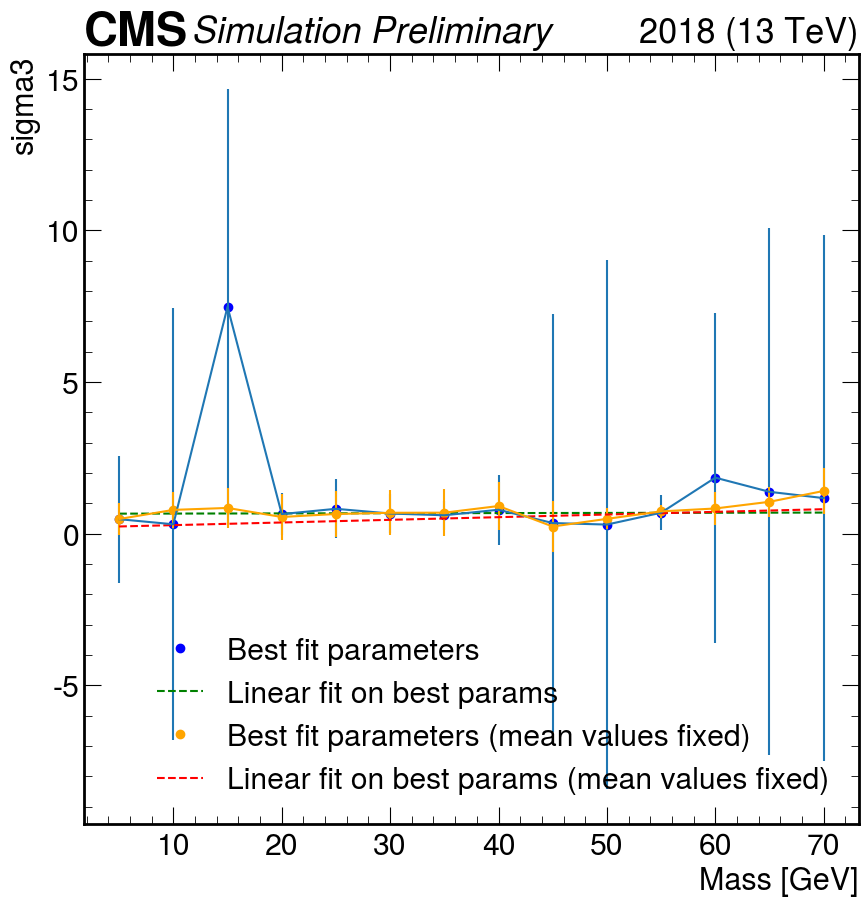

In [7]:
#p_sigma3 = plt.scatter(mass, sigma3, color="blue")

p = np.polyfit(mass, sigma3, 1, w=1/sigma3_err)
#print(p)
x1 = np.linspace(5,70)
f1 = np.polyval(p,x1)

p_mf = np.polyfit(mass, mf_sigma3, 1, w=1/mf_sigma3_err)
print(p_mf) 
f1_mf = np.polyval(p_mf, x1)
v_m.append(p_mf[0])
v_q.append(p_mf[1])

plt.plot(mass, sigma3, 'o', color="blue", label='Best fit parameters')
plt.errorbar(mass, sigma3, yerr=sigma3_err)
plt.plot(x1,f1,'g--', label='Linear fit on best params') 
plt.plot(mass, mf_sigma3, 'o', color="orange", label='Best fit parameters (mean values fixed)')
plt.errorbar(mass, mf_sigma3, yerr=mf_frac2_err, color="orange")
plt.plot(x1,f1_mf,'r--', label='Linear fit on best params (mean values fixed)')

plt.style.use(hep.style.ROOT)
# Overall - both left and right annotation
hep.cms.label("Preliminary", data=False, year="2018")
#hep.cms.label("", data=True, lumi=96.6, year="2017 + 2018")

plt.xlabel('Mass [GeV]', fontsize=22)
plt.ylabel('sigma3', fontsize=22)
#plt.ylim(0.0, 2.5)
plt.legend(loc='lower right')
plt.savefig('simpleFits/sigma3_fit.pdf', dpi=1000)
plt.savefig('simpleFits/sigma3_fit.png', dpi=1000)

[0.99924765 0.00115604]


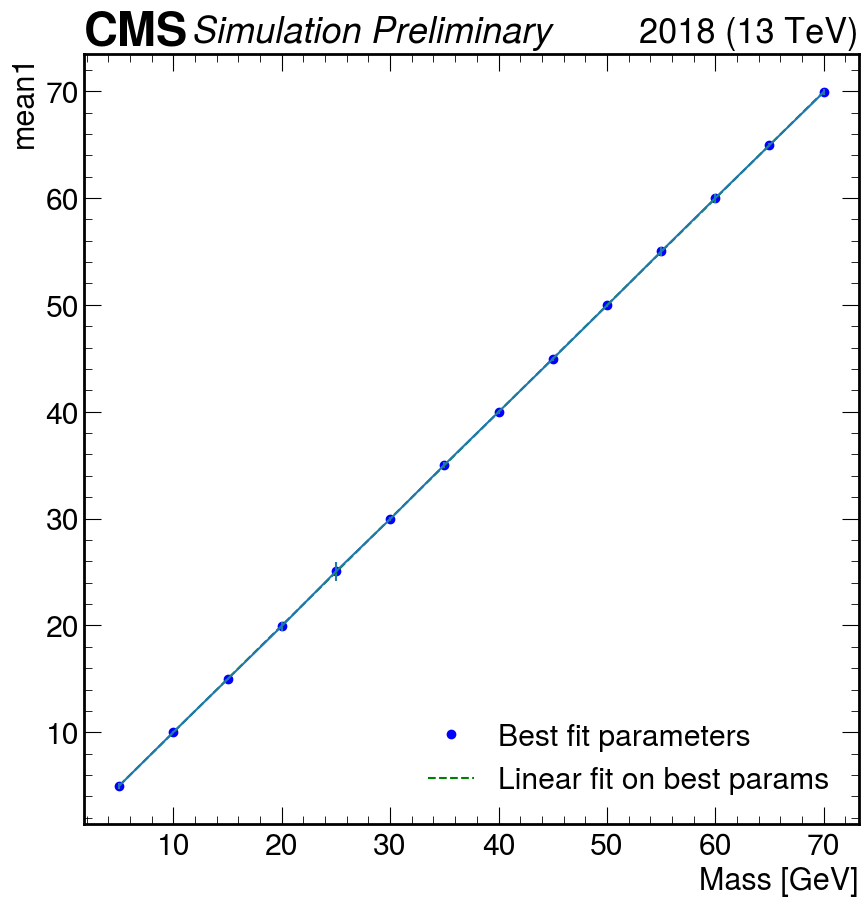

In [8]:
#p_mean1 = plt.scatter(mass, mean1, color="blue")

p = np.polyfit(mass, mean1, 1)
#p = np.polyfit(mass, mean1, 1, w=1/mean1_err)
v_m.append(p[0])
v_q.append(p[1])
print(p)
x1 = np.linspace(5,70)
f1 = np.polyval(p,x1)

plt.plot(mass, mean1, 'o', color="blue", label='Best fit parameters')
plt.errorbar(mass, mean1, yerr=mean1_err)
plt.plot(x1,f1,'g--', label='Linear fit on best params') 

plt.style.use(hep.style.ROOT)
# Overall - both left and right annotation
hep.cms.label("Preliminary", data=False, year="2018")
#hep.cms.label("", data=True, lumi=96.6, year="2017 + 2018")

plt.xlabel('Mass [GeV]', fontsize=22)
plt.ylabel('mean1', fontsize=22)
#plt.ylim(0.0, 1.)
plt.legend(loc='lower right')
plt.savefig('simpleFits/mean1_fit.pdf', dpi=1000)
plt.savefig('simpleFits/mean1_fit.png', dpi=1000)

[ 0.99478394 -0.52057341]


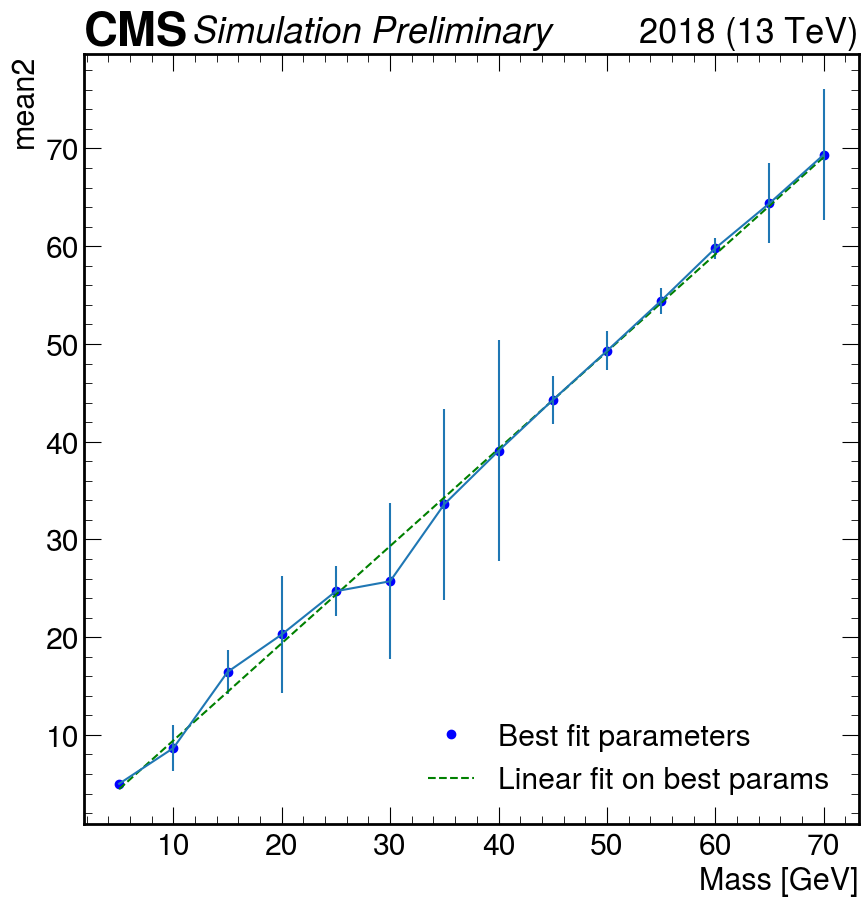

In [9]:
#p_mean2 = plt.scatter(mass, mean2, color="blue")

p = np.polyfit(mass, mean2, 1)
#p = np.polyfit(mass, mean2, 1, w=1/mean2_err)
v_m.append(p[0])
v_q.append(p[1])
print(p)
x1 = np.linspace(5,70)
f1 = np.polyval(p,x1)

plt.plot(mass, mean2, 'o', color="blue", label='Best fit parameters')
plt.errorbar(mass, mean2, yerr=mean2_err)
plt.plot(x1,f1,'g--', label='Linear fit on best params') 

plt.style.use(hep.style.ROOT)
# Overall - both left and right annotation
hep.cms.label("Preliminary", data=False, year="2018")
#hep.cms.label("", data=True, lumi=96.6, year="2017 + 2018")

plt.xlabel('Mass [GeV]', fontsize=22)
plt.ylabel('mean2', fontsize=22)
#plt.ylim(0.0, 1.)
plt.legend(loc='lower right')
plt.savefig('simpleFits/mean2_fit.pdf', dpi=1000)
plt.savefig('simpleFits/mean2_fit.png', dpi=1000)

[0.98373904 0.77512593]


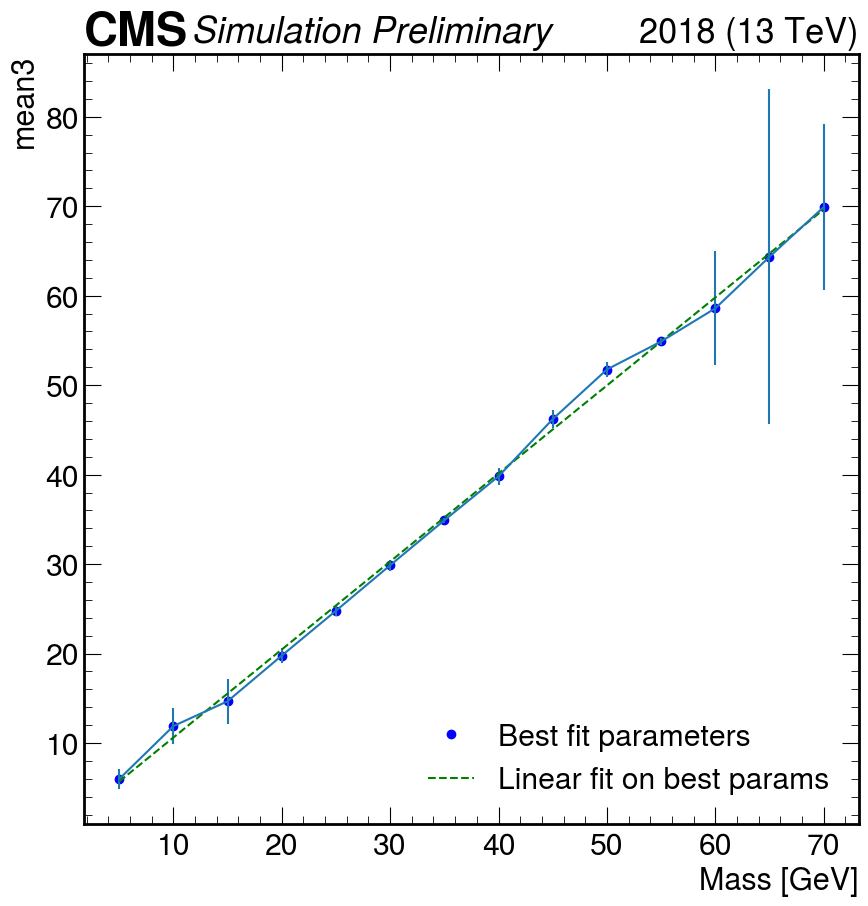

In [10]:
#p_mean3 = plt.scatter(mass, mean3, color="blue")

p = np.polyfit(mass, mean3, 1)
#p = np.polyfit(mass, mean3, 1, w=1/mean3_err)
v_m.append(p[0])
v_q.append(p[1])
print(p)
x1 = np.linspace(5,70)
f1 = np.polyval(p,x1)

plt.plot(mass, mean3, 'o', color="blue", label='Best fit parameters')
plt.errorbar(mass, mean3, yerr=mean3_err)
plt.plot(x1,f1,'g--', label='Linear fit on best params') 

plt.style.use(hep.style.ROOT)
# Overall - both left and right annotation
hep.cms.label("Preliminary", data=False, year="2018")
#hep.cms.label("", data=True, lumi=96.6, year="2017 + 2018")

plt.xlabel('Mass [GeV]', fontsize=22)
plt.ylabel('mean3', fontsize=22)
#plt.ylim(0.0, 1.)
plt.legend(loc='lower right')
plt.savefig('simpleFits/mean3_fit.pdf', dpi=1000)
plt.savefig('simpleFits/mean3_fit.png', dpi=1000)

In [11]:
# Extract all values for the"closure test" from the fits
new_frac1 = []
new_frac2 = []
new_sigma1 = []
new_sigma2 = []
new_sigma3 = []
new_mean1 = []
new_mean2 = []
new_mean3 = []
#print("v_m", v_m)
#print("v_q", v_q)

for m in range(len(mass)):
    #print("mass = ", mass[m])
    new_frac1.append(v_m[0]*mass[m] + v_q[0])
    new_frac2.append(v_m[1]*mass[m] + v_q[1])
    new_sigma1.append(v_m[2]*mass[m] + v_q[2])
    new_sigma2.append(v_m[3]*mass[m] + v_q[3])
    new_sigma3.append(v_m[4]*mass[m] + v_q[4])
    new_mean1.append(v_m[5]*mass[m] + v_q[5])
    new_mean2.append(v_m[6]*mass[m] + v_q[6])
    new_mean3.append(v_m[7]*mass[m] + v_q[7])
    #p_frac1 = polyval(v_frac1_fits[p],x1)
    #plt.plot(x1,p_frac1,l_colors[p], label=v_masspoints[p])
    
print("---------------------------------------------------------")
print("New parameters for each mass point for the closure test: ")
print("---------------------------------------------------------")
print("frac1 = ", new_frac1)
print("frac2 = ", new_frac2)
print("mean1 = ", new_mean1)
print("mean2 = ", new_mean2)
print("mean3 = ", new_mean3)
print("sigma1 = ", new_sigma1)
print("sigma2 = ", new_sigma2)
print("sigma3 = ", new_sigma3)


---------------------------------------------------------
New parameters for each mass point for the closure test: 
---------------------------------------------------------
frac1 =  [0.8681726633568282, 0.832518282442386, 0.796863901527944, 0.7612095206135018, 0.7255551396990597, 0.6899007587846175, 0.6542463778701755, 0.6185919969557334, 0.5829376160412914, 0.5472832351268492, 0.511628854212407, 0.47597447329796494, 0.4403200923835228, 0.4046657114690807]
frac2 =  [0.5740844439816892, 0.5449233610721715, 0.5157622781626537, 0.486601195253136, 0.45744011234361825, 0.4282790294341005, 0.39911794652458277, 0.36995686361506497, 0.3407957807055472, 0.3116346977960295, 0.28247361488651174, 0.253312531976994, 0.22415144906747625, 0.19499036615795845]
mean1 =  [4.997394285714296, 9.993632527472538, 14.989870769230782, 19.986109010989026, 24.98234725274727, 29.978585494505513, 34.97482373626375, 39.97106197802199, 44.967300219780235, 49.963538461538484, 54.959776703296725, 59.95601494505497, 